In [1]:
import torch
import matplotlib.pyplot as plt
from utils.plots import plot_tensors, plot_tensor
from PIL import Image
import torch
import torchvision.transforms as transforms

In [ ]:
n = 5
tau = 3.0
beta = 4.0
templates = []
for i in range(n):
    for j in range(n):
        t = torch.full((n, n), -tau)
        for x in range(n):
            for y in range(n):
                dist = abs(x - i) + abs(y - j)
                t[x, y] = tau * max(1 - beta * dist / n, -1)
        templates.append(t)
templates = torch.stack(templates)

#normalize
templates = templates - templates.min()
templates = templates / templates.max()

In [3]:
templates.shape

torch.Size([25, 5, 5])

/Users/valefeve/Projects/interpretability/utils/plots.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


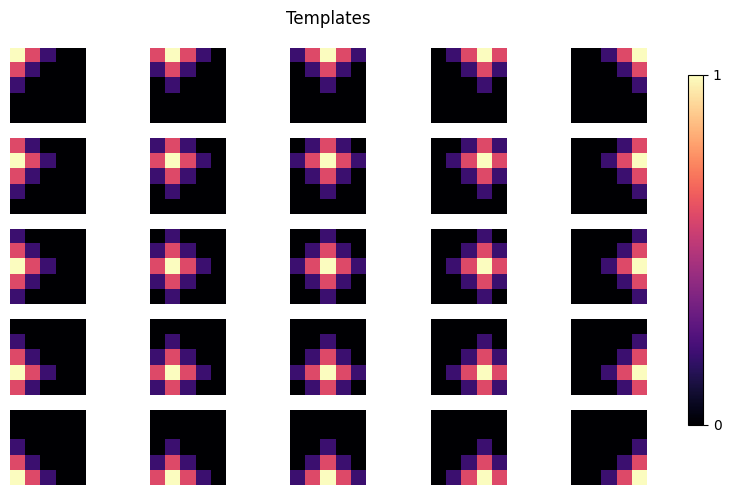

In [4]:
plot_tensors(templates.unsqueeze(0), title="Templates")

In [5]:
templates[20]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6000, 0.2000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.6000, 0.2000, 0.0000, 0.0000]])

In [6]:
t = templates[4]
image = Image.open("examples/lightening_5x5.png")
t_image = transforms.ToTensor()(image).squeeze(0)
image_inverted = Image.open("examples/lightening_5x5_1.png")
t_image_inverted = transforms.ToTensor()(image_inverted).squeeze(0)
X = torch.stack([t_image, t_image_inverted])

In [7]:
print(t.shape)
print(t_image.shape)

torch.Size([5, 5])
torch.Size([5, 5])


In [8]:
t

tensor([[0.0000, 0.0000, 0.2000, 0.6000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.6000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

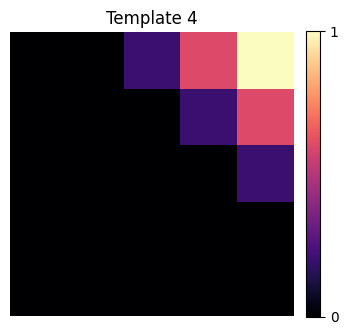

In [9]:
plot_tensor(t.unsqueeze(2), title="Template 4")

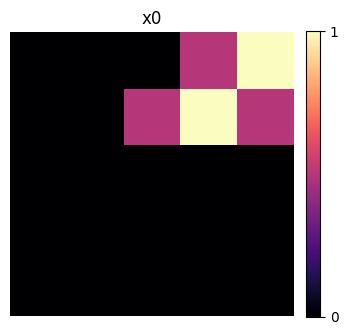

In [10]:
plot_tensor(t_image.unsqueeze(0).permute(1, 2, 0), title="x0")

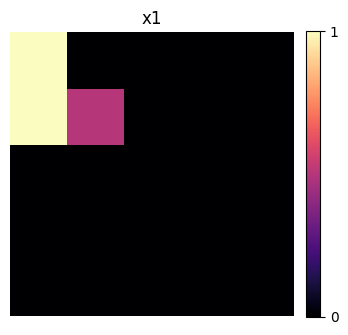

In [11]:
plot_tensor(t_image_inverted.unsqueeze(0).permute(1, 2, 0), title="x1")

In [12]:
tr_x_t = torch.mul(t.unsqueeze(0), t_image.unsqueeze(0))
tr_x_t.shape

torch.Size([1, 5, 5])

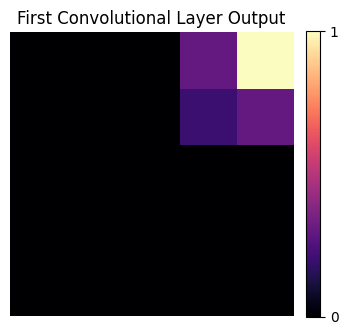

In [13]:
plot_tensor(tr_x_t.permute(1, 2, 0), title="First Convolutional Layer Output")

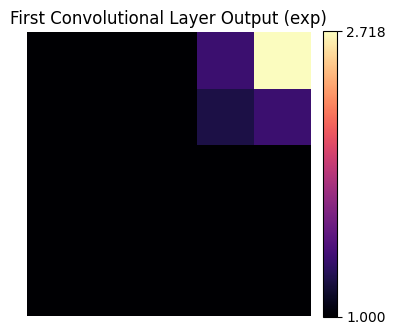

In [14]:
exp = torch.exp(tr_x_t)
plot_tensor(exp.permute(1, 2, 0), title="First Convolutional Layer Output (exp)")

In [15]:
print(X.shape)
print(templates.shape)

torch.Size([2, 5, 5])
torch.Size([25, 5, 5])


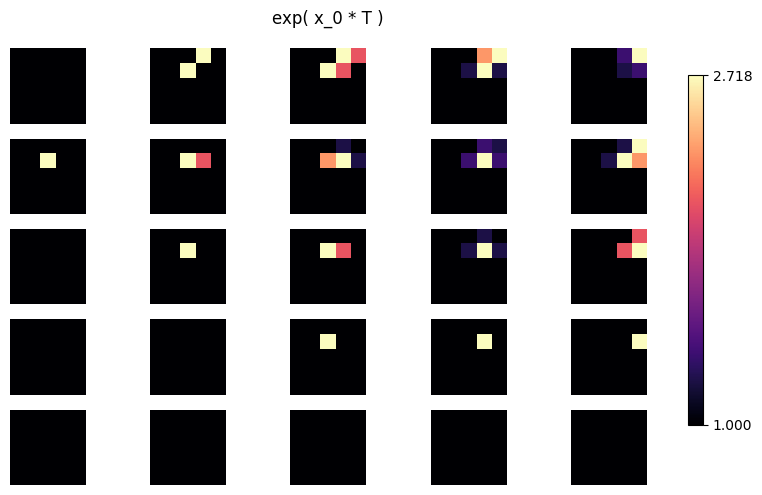

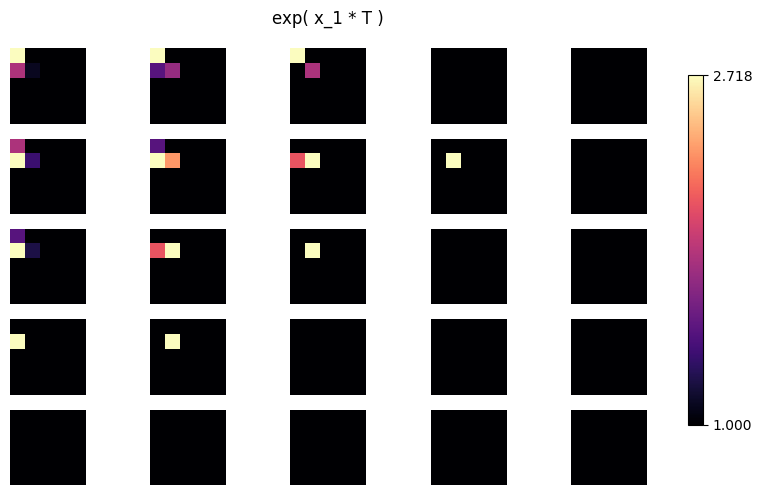

In [16]:
tr_x_ts = []
for x_i in range(X.shape[0]):
    tr_x_t = torch.exp(torch.mul(templates, X[x_i].unsqueeze(0)))
    tr_x_ts.append(tr_x_t)
    plot_tensors(tr_x_t.unsqueeze(0), title=f"exp( x_{x_i} * T )")

In [17]:
Z = torch.stack(tr_x_ts).sum(dim=0)
Z.shape

torch.Size([25, 5, 5])

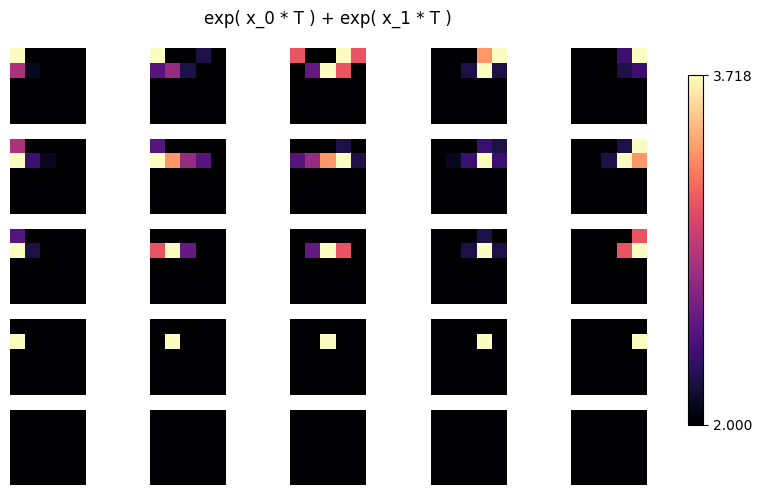

In [18]:
plot_tensors(Z.unsqueeze(0), title="exp( x_0 * T ) + exp( x_1 * T )")

In [19]:
p_x0_T = (1 / Z) * tr_x_ts[0]
p_x0_T.shape

torch.Size([25, 5, 5])

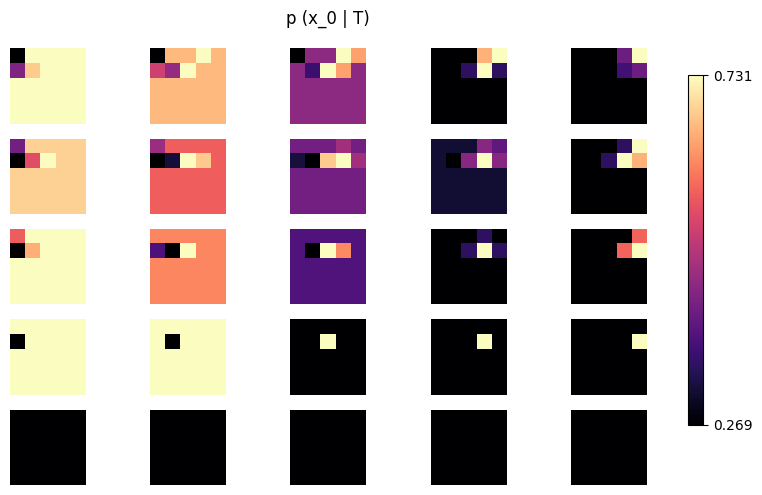

In [20]:
plot_tensors(p_x0_T.unsqueeze(0), title="p (x_0 | T)")

In [21]:
print(X.shape)
print(templates.shape)

torch.Size([2, 5, 5])
torch.Size([25, 5, 5])


In [22]:
templates.unsqueeze(1).shape

torch.Size([25, 1, 5, 5])

In [23]:
def calculate_p_x_T(X, templates):
    tr_x_ts = torch.exp(torch.mul(templates.unsqueeze(0), X.unsqueeze(1)))
    Z = tr_x_ts.sum(dim=(0))
    p_x_T = (1 / Z) * tr_x_ts
    return p_x_T

In [24]:
calculate_p_x_T(X, templates)

tensor([[[[0.2689, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.3543, 0.4751, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         [[0.3543, 0.5000, 0.5000, 0.5249, 0.5000],
          [0.4502, 0.4258, 0.5249, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         [[0.4502, 0.5000, 0.5000, 0.5742, 0.5498],
          [0.5000, 0.4751, 0.5742, 0.5498, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         ...,

         [[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 

In [25]:
def calculate_p_x_T(X, templates):
    tr_x_ts = torch.exp(torch.mul(templates.unsqueeze(1), X.unsqueeze(2)))
    Z = tr_x_ts.sum(dim=(0))
    p_x_T = (1 / Z) * tr_x_ts
    return p_x_T

In [26]:
def mutual_information(X, templates):
    n = templates.shape[-1]
    filters = X.shape[0]

    p_x_T_extended = calculate_p_x_T(X, templates)
    p_X = 1 / (n*n + 1)
    sum_p_T = p_X * (n*n)
    sum_p_X = sum_p_T * p_x_T_extended.sum(dim=(2))
    p_x_T = p_x_T_extended.sum(dim=(1, 2))
    mi = - sum_p_X.sum(dim=(1)) * p_x_T * torch.log((p_x_T) / (sum_p_X)).sum(dim=(1))
    return mi.sum()

In [27]:
print(X.shape, templates.shape)

torch.Size([2, 5, 5]) torch.Size([25, 5, 5])


In [28]:
X[0, :, :].shape

torch.Size([5, 5])

In [29]:
mutual_information(X[0, :, :].unsqueeze(0).unsqueeze(0), templates.unsqueeze(0))

tensor(-589.2529)

In [30]:
mutual_information(X[1, :, :].unsqueeze(0).unsqueeze(0), templates.unsqueeze(0))

tensor(-589.2529)

In [31]:
X[0, :, :]

tensor([[0.0000, 0.0000, 0.0000, 0.4980, 1.0000],
        [0.0000, 0.0000, 0.4980, 1.0000, 0.4980],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [32]:
X[1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.4980, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])